In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
import sklearn.metrics
import pandas as pd

import dataset
import data_reader
import plots

In [2]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [3]:
EXP_NAME = "25ep0"#"tcia_25ep"

DATA_SET_NAME = f"data_set_X20_100%_SPLIT"#"tcia_data_set_SPLIT"

In [4]:
def wsi_class(wsi_data_set):
    global net
    """
    Input: 
    - wsi_data_set, patches from a given WSI, dataset object
    - y, patch labels
    Outputs:
    - output, Prediction
    """
    wsi_dataloader = DataLoader(wsi_data_set, batch_size=64)
    outputs = []
    loss = 0

    for batch_X, batch_y in iter(wsi_dataloader):
        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device) 

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        normalize = transforms.Normalize(mean=mean, std=std)

        for i, x in enumerate(batch_X):
            batch_X[i] = normalize(batch_X[i]/255) # Np array
    
        output = net(batch_X)
        outputs.extend(output.cpu())
        
        loss += nn.CrossEntropyLoss()(output, batch_y).cpu()

    #print(outputs)

    y_pred = [torch.argmax(i) for i in outputs] # 1 means positive diagnosis: (1,0) => 1
    prob_neg = y_pred.count(0)/len(y_pred)
    prob_pos = y_pred.count(1)/len(y_pred)

    output = [prob_neg, prob_pos]
    loss = loss/len(wsi_data_set)

    return output, loss

data_set_X20_100%_SPLIT1
Read lmdb
8207


  0%|          | 0/52 [00:00<?, ?it/s]

c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\torch\utils\data\_utils\collate.py:146: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  return default_collate([torch.as_tensor(b) for b in batch])


Mean Loss:  0.009576947
Acc:  0.9230769230769231
f1:  0.9
CONF: 
 [[30  4]
 [ 0 18]] 

data_set_X20_100%_SPLIT2
Read lmdb
9777


  0%|          | 0/51 [00:00<?, ?it/s]

Mean Loss:  0.009312212
Acc:  0.9019607843137255
f1:  0.8648648648648649
CONF: 
 [[30  3]
 [ 2 16]] 

data_set_X20_100%_SPLIT3
Read lmdb
9243


  0%|          | 0/52 [00:00<?, ?it/s]

Mean Loss:  0.010736378
Acc:  0.75
f1:  0.6486486486486486
CONF: 
 [[27  6]
 [ 7 12]] 

data_set_X20_100%_SPLIT4
Read lmdb
8730


  0%|          | 0/52 [00:00<?, ?it/s]

Mean Loss:  0.009797827
Acc:  0.9038461538461539
f1:  0.8717948717948718
CONF: 
 [[30  3]
 [ 2 17]] 

data_set_X20_100%_SPLIT5
Read lmdb
8520


  0%|          | 0/53 [00:00<?, ?it/s]

Mean Loss:  0.010447297
Acc:  0.8867924528301887
f1:  0.8333333333333333
CONF: 
 [[32  2]
 [ 4 15]] 

data_set_X20_100%_SPLIT6
Read lmdb
8464


  0%|          | 0/51 [00:00<?, ?it/s]

Mean Loss:  0.008959981
Acc:  0.9607843137254902
f1:  0.9444444444444444
CONF: 
 [[32  1]
 [ 1 17]] 

data_set_X20_100%_SPLIT7
Read lmdb
8236


  0%|          | 0/51 [00:00<?, ?it/s]

Mean Loss:  0.009398726
Acc:  0.9019607843137255
f1:  0.878048780487805
CONF: 
 [[28  5]
 [ 0 18]] 

data_set_X20_100%_SPLIT8
Read lmdb
7714


  0%|          | 0/51 [00:00<?, ?it/s]

Mean Loss:  0.011939272
Acc:  0.8823529411764706
f1:  0.85
CONF: 
 [[28  5]
 [ 1 17]] 

data_set_X20_100%_SPLIT9
Read lmdb
9329


  0%|          | 0/51 [00:00<?, ?it/s]

Mean Loss:  0.008971892
Acc:  0.8823529411764706
f1:  0.823529411764706
CONF: 
 [[31  2]
 [ 4 14]] 

data_set_X20_100%_SPLIT0
Read lmdb
8209


  0%|          | 0/52 [00:00<?, ?it/s]

Mean Loss:  0.011014888
Acc:  0.8461538461538461
f1:  0.7999999999999999
CONF: 
 [[28  6]
 [ 2 16]] 

[[296.  37.]
 [ 23. 160.]]


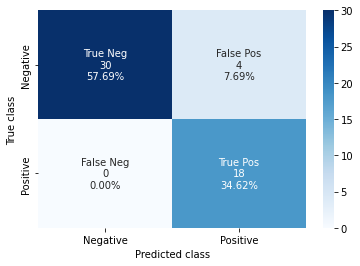

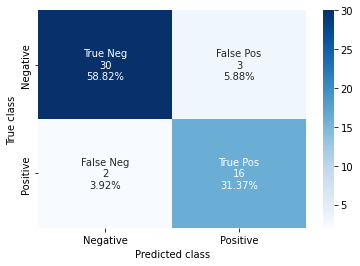

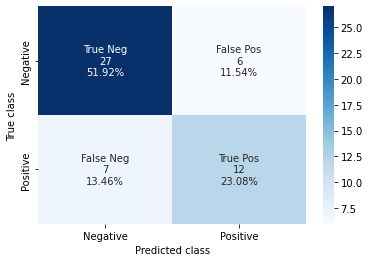

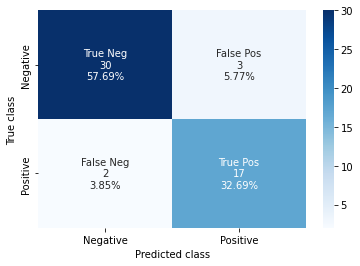

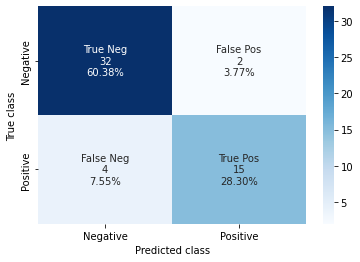

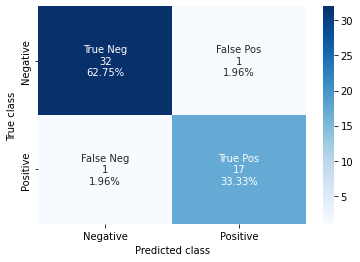

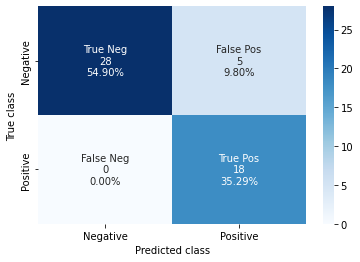

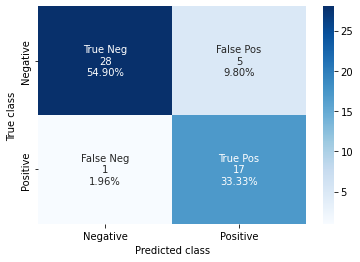

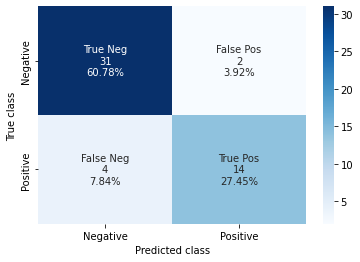

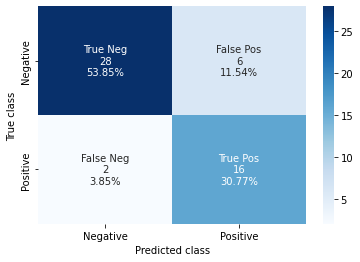

In [5]:
n_splits = 10
tot_conf = np.zeros((2,2))
tot_out, tot_labels, accs, f1s, losses = [], [], [], [], []

for SPLIT in range(n_splits):

    test_out = pd.DataFrame(columns=["Sample ID", "Output", "Label"])
    
    if SPLIT == n_splits-1: # For the final split for validation we take the firs one for test
        SPLIT_NAME = DATA_SET_NAME + f"{0}" # Test set 
    else:
        SPLIT_NAME = DATA_SET_NAME + f"{SPLIT+1}" # Test set
    
    MODEL_NAME = EXP_NAME + f"{SPLIT}"
    MODEL_NAME = "tcia_25ep2"

    print(SPLIT_NAME)

    net = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading

    X, y, _ , case_ids = data_reader.read_lmdb(f"D:\data\WSI\patches\{SPLIT_NAME}")

    sample_ids = [case_id.split("_")[1] for case_id in case_ids] # Taking only the sample_id, not patch id

    outputs, loss, labels = [], [], []
    unique_sample_ids = np.unique(sample_ids)
    sample_ids = np.array(sample_ids)

    for unique_sample_id in tqdm(unique_sample_ids):

        net.eval()
        with torch.no_grad():
    
            ii = np.where(sample_ids == unique_sample_id)[0]

            wsi_data_set = dataset.PatchDataset([], [], [])

            wsi_data_set.inputs.extend(X[ii[0]:ii[-1]])# Taking the patches from a given wsi
            wsi_data_set.labels.extend(y[ii[0]:ii[-1]])
            wsi_data_set.case_ids.extend(sample_ids)

            if len(wsi_data_set) == 0:
                print("No patches")
                outputs.append([np.nan,np.nan])
                labels.append(np.argmax(y[ii[0]]))
                pass
            else:
                output = wsi_class(wsi_data_set)
                outputs.append(output[0])
                loss.append(output[1])
                labels.append(np.argmax(y[ii[0]])) # OHE to binary

            del wsi_data_set

    loss = np.mean(loss)

    out = [np.argmax(output) for output in outputs]

    conf_m = sklearn.metrics.confusion_matrix(labels, out, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(labels, out)
    f1 = sklearn.metrics.f1_score(labels, out)
    auc = 0 #sklearn.metrics.roc_auc_score(y_true, y_pred, average= "micro", multi_class="ovr") #!!!!

    tot_out += out
    tot_labels += labels

    print("Mean Loss: ", loss)
    print("Acc: ", acc)
    print("f1: ", f1)
    print("CONF: \n", conf_m, "\n")

    tot_conf += conf_m

    plots.plot_conf(SPLIT_NAME, conf_m)
    
    test_out["Sample ID"] = unique_sample_ids # The samples are ordered since the loop goes through unique_sample_ids
    test_out["Output"] = [output[0] for output in outputs]
    test_out["Label"] = labels

    #test_out.to_csv(f"D:\data\Outputs\WSI\PDAC_test_{SPLIT+1}.csv")

    accs.append(acc)
    f1s.append(f1)
    losses.append(loss)

tot_acc = np.mean(accs)
tot_f1 = np.mean(f1s)
tot_loss = np.mean(losses)

err_acc = np.std(accs)
err_f1 = np.std(f1s)
err_loss = np.std(losses)

print(tot_conf)

0.8837209302325582
0.8421052631578948


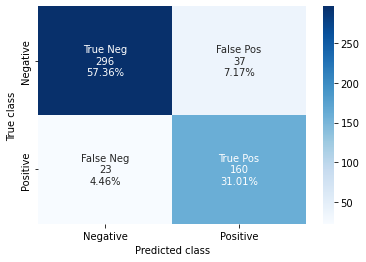

In [9]:
print(tot_acc)
print(tot_f1)

plots.plot_conf("10CV", tot_conf)


In [7]:
roc = []


# ROC
for i in reversed(np.linspace(0,1,10000)):
    out = [1 if output>i else 0 for output in outputs]
    conf_m = confusion_matrix(labels, out, labels=[0, 1])
    roc.append(conf_m[1][1]/(conf_m[1][0]+conf_m[1][1]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
plots.plot_roc(SPLIT_NAME, roc)

In [37]:
n_splits = 10
tot_conf = np.zeros((2,2))
tot_out, tot_labels = [], []

#Generating the training outputs PDAC_TEST_(MODEL NUMBER)_(SPLIT OUTPUT)

for TEST_SPLIT in [0,1,2,3]:#range(n_splits):

    MODEL_NAME = EXP_NAME + f"{TEST_SPLIT}"
    net = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading

    for SPLIT in range(n_splits):
        #This has already been executed
        if SPLIT+1==TEST_SPLIT:
            pass

        test_out = pd.DataFrame(columns=["Sample ID", "Output", "Label"])
        
        if SPLIT == n_splits-1: # For the final split for validation we take the first one for test
            SPLIT_NAME = DATA_SET_NAME + f"{0}" # Test set 
        else:
            SPLIT_NAME = DATA_SET_NAME + f"{SPLIT+1}" # Test set

        print(SPLIT_NAME)

        X, y, _ , case_ids = data_reader.read_lmdb(f"D:\data\WSI\patches\{SPLIT_NAME}")

        sample_ids = [case_id.split("_")[1] for case_id in case_ids] # Taking only the sample_id, not patch id

        outputs, loss, labels = [], [], []
        unique_sample_ids = np.unique(sample_ids)
        sample_ids = np.array(sample_ids)

        for unique_sample_id in tqdm(unique_sample_ids):

            net.eval()
            with torch.no_grad():
        
                ii = np.where(sample_ids == unique_sample_id)[0]

                wsi_data_set = dataset.PatchDataset([], [], [])

                wsi_data_set.inputs.extend(X[ii[0]:ii[-1]])# Taking the patches from a given wsi
                wsi_data_set.labels.extend(y[ii[0]:ii[-1]])
                wsi_data_set.case_ids.extend(sample_ids)

                if len(wsi_data_set) == 0:
                    print("No patches")
                    outputs.append([np.nan,np.nan])
                    labels.append(np.argmax(y[ii[0]]))
                    pass
                else:
                    output = wsi_class(wsi_data_set)
                    outputs.append(output[0])
                    loss.append(output[1])
                    labels.append(np.argmax(y[ii[0]])) # OHE to binary

                del wsi_data_set
        
        test_out["Sample ID"] = unique_sample_ids # The samples are ordered since the loop goes through unique_sample_ids
        test_out["Output"] = [output[0] for output in outputs]
        test_out["Label"] = labels

        test_out.to_csv(f"D:\data\Outputs\WSI\PDAC_train_{TEST_SPLIT}_{SPLIT+1}.csv")


tcia_data_set_SPLIT1
Read lmdb
23065


  0%|          | 0/62 [00:00<?, ?it/s]

No patches
tcia_data_set_SPLIT2
Read lmdb
20366


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT3
Read lmdb
20818


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT4
Read lmdb
20947


  0%|          | 0/59 [00:00<?, ?it/s]

tcia_data_set_SPLIT5
Read lmdb
26374


  0%|          | 0/62 [00:00<?, ?it/s]

No patches
tcia_data_set_SPLIT6
Read lmdb
14995


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT7
Read lmdb
10407


  0%|          | 0/44 [00:00<?, ?it/s]

tcia_data_set_SPLIT8
Read lmdb
22786


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT9
Read lmdb
19800


  0%|          | 0/50 [00:00<?, ?it/s]

tcia_data_set_SPLIT0
Read lmdb
18709


  0%|          | 0/55 [00:00<?, ?it/s]

tcia_data_set_SPLIT1
Read lmdb
23065


  0%|          | 0/62 [00:00<?, ?it/s]

No patches
tcia_data_set_SPLIT2
Read lmdb
20366


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT3
Read lmdb
20818


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT4
Read lmdb
20947


  0%|          | 0/59 [00:00<?, ?it/s]

tcia_data_set_SPLIT5
Read lmdb
26374


  0%|          | 0/62 [00:00<?, ?it/s]

No patches
tcia_data_set_SPLIT6
Read lmdb
14995


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT7
Read lmdb
10407


  0%|          | 0/44 [00:00<?, ?it/s]

tcia_data_set_SPLIT8
Read lmdb
22786


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT9
Read lmdb
19800


  0%|          | 0/50 [00:00<?, ?it/s]

tcia_data_set_SPLIT0
Read lmdb
18709


  0%|          | 0/55 [00:00<?, ?it/s]

tcia_data_set_SPLIT1
Read lmdb
23065


  0%|          | 0/62 [00:00<?, ?it/s]

No patches
tcia_data_set_SPLIT2
Read lmdb
20366


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT3
Read lmdb
20818


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT4
Read lmdb
20947


  0%|          | 0/59 [00:00<?, ?it/s]

tcia_data_set_SPLIT5
Read lmdb
26374


  0%|          | 0/62 [00:00<?, ?it/s]

No patches
tcia_data_set_SPLIT6
Read lmdb
14995


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT7
Read lmdb
10407


  0%|          | 0/44 [00:00<?, ?it/s]

tcia_data_set_SPLIT8
Read lmdb
22786


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT9
Read lmdb
19800


  0%|          | 0/50 [00:00<?, ?it/s]

tcia_data_set_SPLIT0
Read lmdb
18709


  0%|          | 0/55 [00:00<?, ?it/s]

tcia_data_set_SPLIT1
Read lmdb
23065


  0%|          | 0/62 [00:00<?, ?it/s]

No patches
tcia_data_set_SPLIT2
Read lmdb
20366


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT3
Read lmdb
20818


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT4
Read lmdb
20947


  0%|          | 0/59 [00:00<?, ?it/s]

tcia_data_set_SPLIT5
Read lmdb
26374


  0%|          | 0/62 [00:00<?, ?it/s]

No patches
tcia_data_set_SPLIT6
Read lmdb
14995


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT7
Read lmdb
10407


  0%|          | 0/44 [00:00<?, ?it/s]

tcia_data_set_SPLIT8
Read lmdb
22786


  0%|          | 0/56 [00:00<?, ?it/s]

tcia_data_set_SPLIT9
Read lmdb
19800


  0%|          | 0/50 [00:00<?, ?it/s]

tcia_data_set_SPLIT0
Read lmdb
18709


  0%|          | 0/55 [00:00<?, ?it/s]